## 1. Mean-smooth a time series

In [1]:
#Adding the required Libraries: 
from scipy import interpolate
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import warnings
from decimal import Decimal 

In [61]:
# creating signals
sample_rate = 1000 #Hz
time = np.arange(0,3,1/sample_rate)
n = len(time)
p = 15 # poles for random interpolation
noise_amp = 5
k = 20
window_size = 1000*(2*k+1) / sample_rate

In [62]:
amp1 = interpolate.interp1d(np.linspace(1,p,p),np.random.rand(p)*30)(np.linspace(1,p,n))
noise = noise_amp * np.random.randn(time.size)
signal = amp1 + noise 

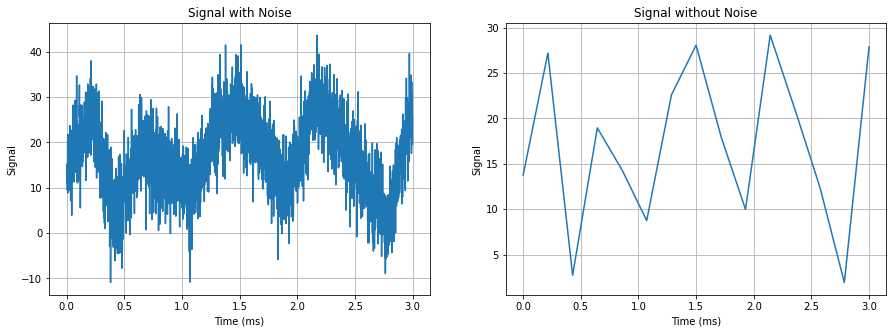

In [63]:
fig , ax = plt.subplots(nrows=1 , ncols = 2, figsize=(15,5))
ax[0].plot(time,signal)
ax[0].grid()
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Signal')
ax[0].set_title('Signal with Noise')

ax[1].plot(time,amp1)
ax[1].grid()
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Signal')
ax[1].set_title('Signal without Noise');

In [64]:
filtered_signal = np.zeros(signal.shape)
for i in range(k+1,n-k):
    filtered_signal[i] = np.mean(signal[i-k:i+k])

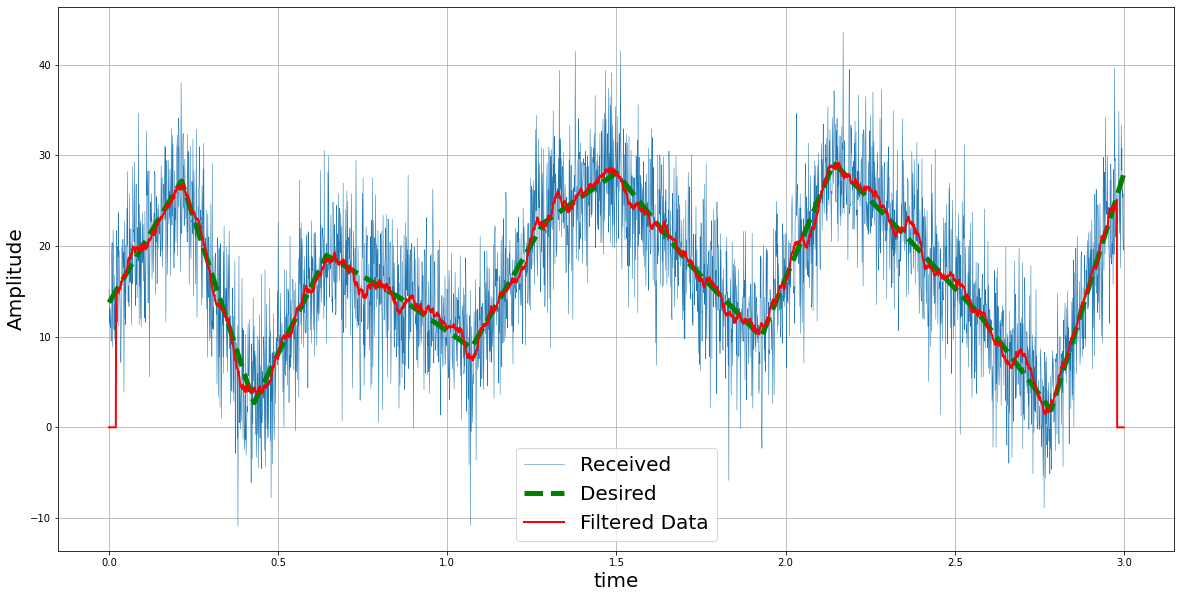

In [65]:
plt.figure(figsize=(20,10))
plt.plot(time,signal,linewidth=0.5, label='Received')
plt.plot(time,amp1 , color = 'g',linewidth=5, label='Desired' , linestyle = 'dashed')
plt.plot(time,filtered_signal,color='r',linewidth = 2 , label = 'Filtered Data')
plt.grid()
plt.xlabel('time',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.legend(fontsize=20);

## 2. Gaussian-smooth a time series

In [66]:
# Full-width Half-Maximum 
fwhm = 25.565768 # in ms
k = 40
Precision = 1000 /(sample_rate)
gtime = Precision * np.arange(-k,k+1)
gaussian = np.exp(-(4*np.log(2)*gtime**2)/fwhm**2)

In [67]:
if Precision == round(Precision):
    Precision = int(Precision)
d_p = np.abs(Decimal(str(Precision)).as_tuple().exponent)
d_f = np.abs(Decimal(str(fwhm)).as_tuple().exponent)
if d_f > d_p:
    warnings.warn("Resolution Warning!")
    print('Resolution lower than {} ms is expected for fwhm, {} ms received.'.format(1/10**d_p,1/10**d_f))

Resolution lower than 1.0 ms is expected for fwhm, 1e-06 ms received.


E:\Python\conda_project\first_project\env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Resolution Warning!
  


In [68]:
def searchN(Array,number):
    peak = Array.argmax()
    
    pre_max_array = Array[:peak]
    post_max_array = Array[peak:]
    
    pre_shape = pre_max_array.shape
    post_shape = post_max_array.shape
    
    pre_vector = np.ones(pre_shape)*(number)
    post_vector = np.ones(post_shape)*(number)
    
    pre_peak = spatial.distance.cdist(np.reshape(pre_vector,(-1,1)),
                                      np.reshape(pre_max_array,(-1,1)))[0].argmin()
    post_peak = peak + spatial.distance.cdist(np.reshape(post_vector,(-1,1)),
                                              np.reshape(post_max_array,(-1,1)))[0].argmin()
    return [pre_peak , post_peak]

In [69]:
empricalFWHM = np.abs(gtime[searchN(gaussian,0.5)][0] - gtime[searchN(gaussian,0.5)][1]) 

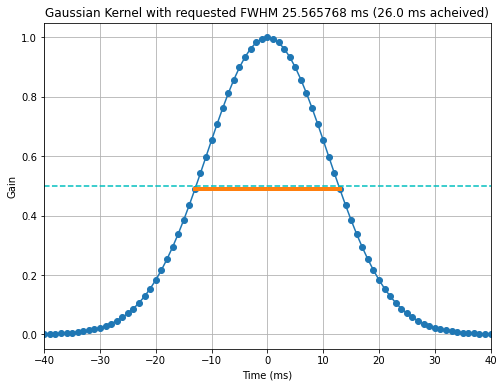

In [70]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(gtime,gaussian,marker='o')
ax.plot(gtime[searchN(gaussian,0.5)] , gaussian[searchN(gaussian,0.5)] , linewidth = 4)
ax.set(title= 'Gaussian Kernel with requested FWHM {} ms ({} ms acheived)'.format(fwhm,empricalFWHM),
       xlabel = 'Time (ms)',
       ylabel = "Gain",
       xlim = [-k,k])
ax.axhline(y = 0.5 , linestyle = 'dashed' , color = 'c')
ax.grid()

In [71]:
gaussian = gaussian / gaussian.sum()

In [72]:
filtered_signal_gauss = np.zeros(signal.shape)
for i in range(k+1,n-k):
    filtered_signal_gauss[i] = np.sum(signal[i-k:i+k+1]*gaussian)

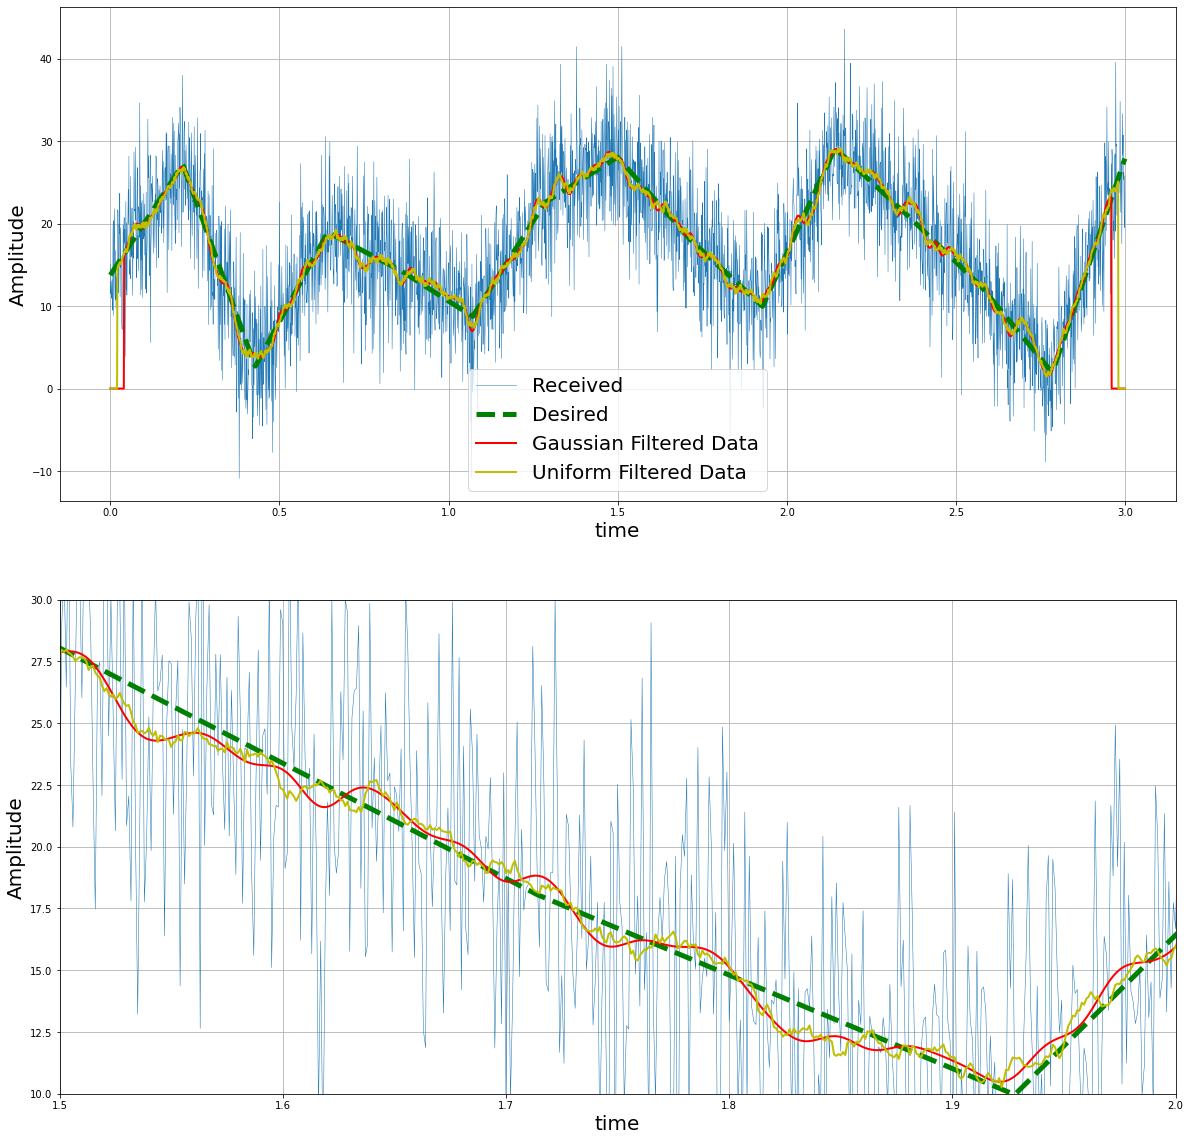

In [74]:
fig,ax = plt.subplots(nrows = 2,
                      ncols = 1, 
                      figsize=(20,20))
ax[0].plot(time,signal,linewidth=0.5, label='Received')
ax[0].plot(time,amp1 , color = 'g',linewidth=5, label='Desired' , linestyle = 'dashed')
ax[0].plot(time,filtered_signal_gauss,color='r',linewidth = 2 , label = 'Gaussian Filtered Data')
ax[0].plot(time,filtered_signal,color='y',linewidth = 2 , label = 'Uniform Filtered Data')
ax[0].grid()
ax[0].set_xlabel('time', fontsize = 20)
ax[0].set_ylabel('Amplitude',fontsize=20)
ax[0].legend(fontsize=20);


ax[1].plot(time,signal,linewidth=0.5, label='Received')
ax[1].plot(time,amp1 , color = 'g',linewidth=5, label='Desired' , linestyle = 'dashed')
ax[1].plot(time,filtered_signal_gauss,color='r',linewidth = 2 , label = 'Gaussian Filtered Data')
ax[1].plot(time,filtered_signal,color='y',linewidth = 2 , label = 'Uniform Filtered Data')
ax[1].grid()
ax[1].set_xlabel('time', fontsize = 20)
ax[1].set_ylabel('Amplitude',fontsize=20)
ax[1].set_xlim([1.5,2])
ax[1].set_ylim([10,30]);

## 3. Gaussian-smooth a spike time series

Creating the Spike time-series: 

In [15]:
n = 100
isi = np.round(np.exp(np.random.randint(0 , 3 , (n,1)))*10)

In [16]:
spikets = np.array([]) ; #np.zeros(isi.sum())
for i in isi:
    spike = np.append( 1 , np.zeros(int(i)))
    spikets = np.append(spikets , spike)

Utilizing Gaussian kernel for smoothing: 

In [17]:
# Full-width Half-Maximum 
fwhm = 25 # in ms
k = 200
sample_rate = 1000 #Hz
Precision = 1000 /(sample_rate)
gtime = Precision * np.arange(-k,k+1)
gaussian = np.exp(-(4*np.log(2)*gtime**2)/fwhm**2)
gaussian = gaussian / gaussian.sum()

smooth_spike_gauss = np.zeros(spikets.shape)
for i in range(k+1,len(spikets)-k):
    smooth_spike_gauss[i] = np.sum(spikets[i-k:i+k+1]*gaussian)

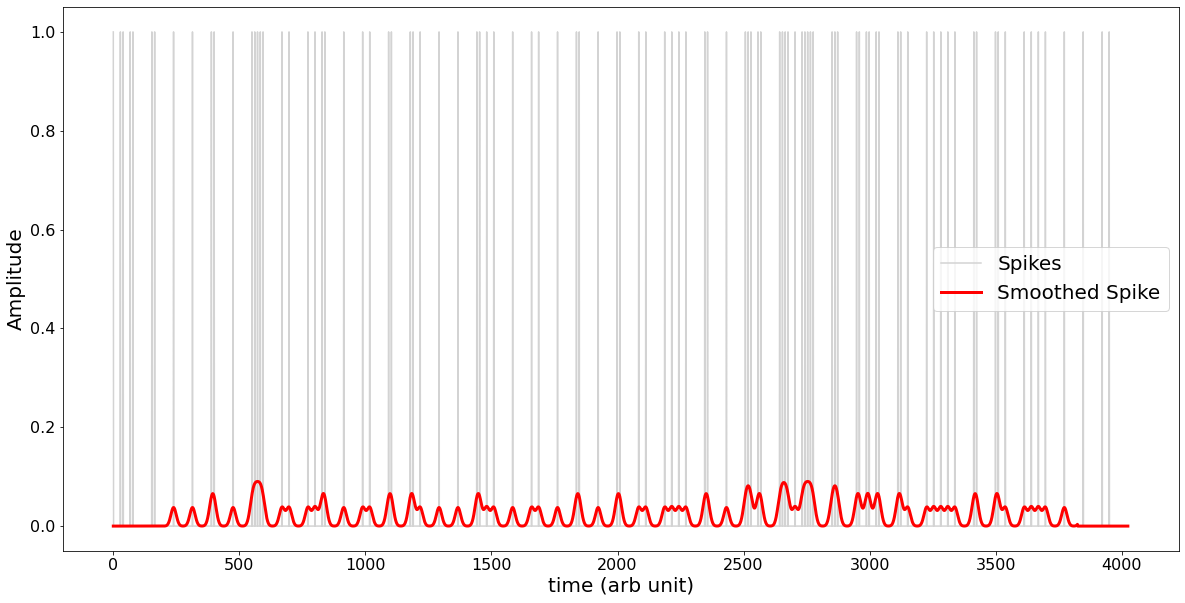

In [18]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(spikets , color = 'lightgrey',label='Spikes')
ax.plot(smooth_spike_gauss , color = 'r' , linewidth = 3,label='Smoothed Spike')
ax.set_xlabel('time (arb unit)' , fontsize = 20)
ax.set_ylabel('Amplitude' , fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize = 20 , loc='best');

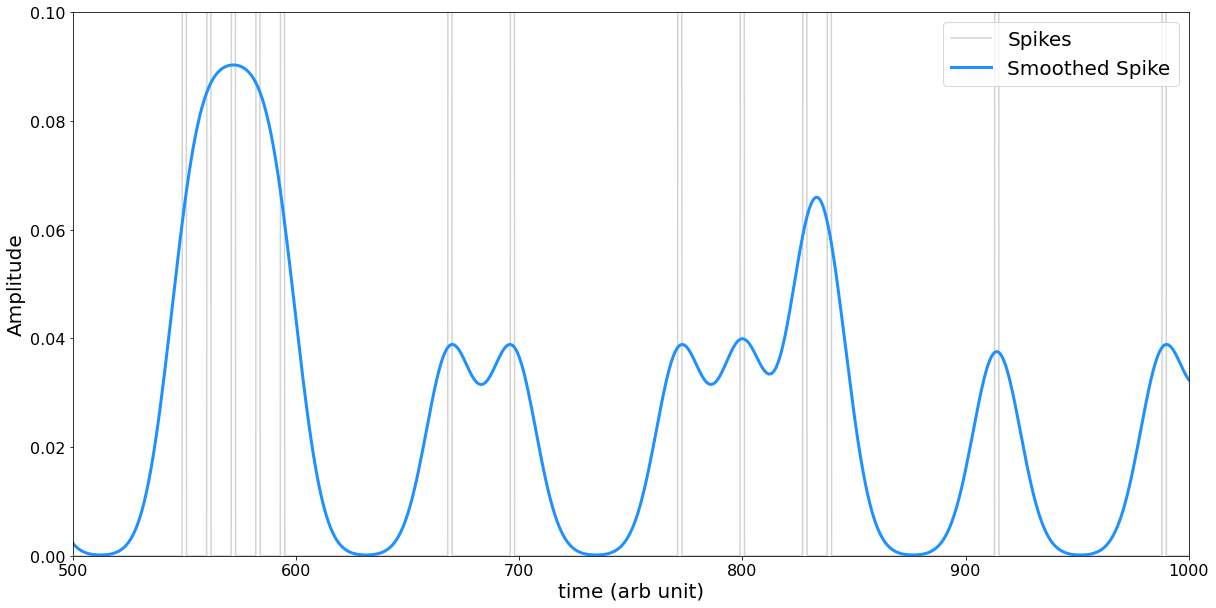

In [19]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(spikets , color = 'lightgrey',label='Spikes')
ax.plot(smooth_spike_gauss , color = 'dodgerblue' , linewidth = 3,label='Smoothed Spike')
ax.set_xlim([500,1000])
ax.set_ylim([0 , 0.1])
ax.set_xlabel('time (arb unit)' , fontsize = 20)
ax.set_ylabel('Amplitude' , fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize = 20 , loc='best');

## 4. Denoising EMG signals via TKEO

In [20]:
from scipy.io import loadmat
x = loadmat('emg4TKEO.mat')

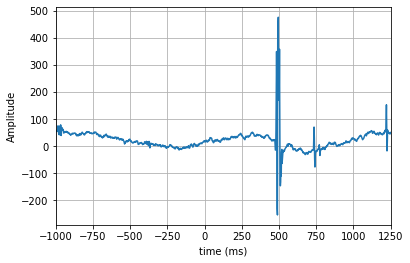

In [21]:
emg = np.reshape(x['emg'] , (-1,1))
emg_time = np.reshape(x['emgtime'] , (-1,1))
plt.plot(emg_time , emg) 
plt.grid()
plt.xlabel('time (ms)')
plt.ylabel('Amplitude')
plt.xlim([-1000,1250]); 

Finding TKEO of the signal: 

In [22]:
emg_f = np.zeros(len(emg))
for i in range(1,len(emg)-1):
    emg_f[i] = emg[i]**2 - emg[i-1]*emg[i+1]

Applying zscore:

In [23]:
emgz = emg - np.mean(emg) / np.sqrt(np.var(emg))
emg_fz = emg_f - np.mean(emg_f) / np.sqrt(np.var(emg_f))

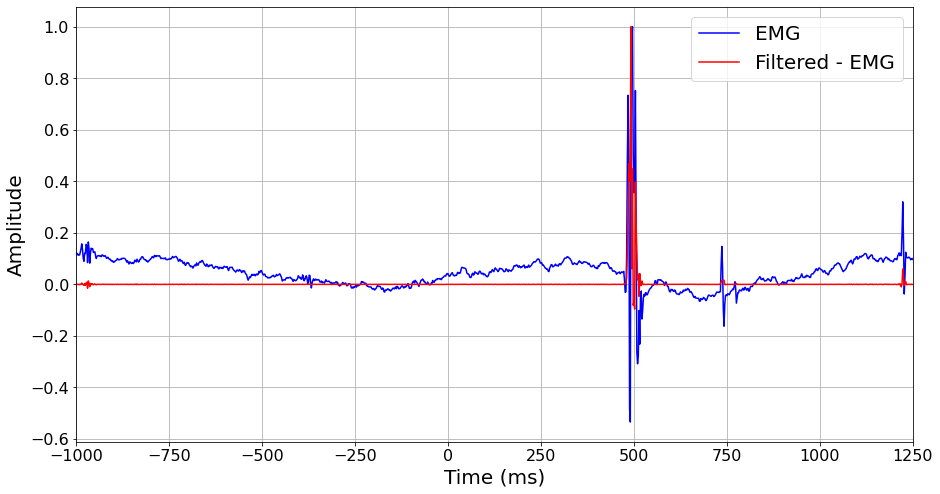

In [24]:
fig,ax = plt.subplots(figsize = (15,8))
ax.plot(emg_time , emgz/np.max(emgz) , label = 'EMG' , color = 'blue')
ax.plot(emg_time , emg_fz/np.max(emg_fz) , label = 'Filtered - EMG' , color = 'red')
ax.set_xlim([-1000,1250])
ax.set_xlabel('Time (ms)' , fontsize = 20)
ax.set_ylabel('Amplitude' , fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize = 20 , loc='best');
ax.grid();

## 5. Median filter to remove spike noise

In [25]:
n = 2000
noise_propotion = 0.05
signal = np.cumsum(np.random.randn(n))

random_list = np.random.permutation(n) 
selected_index_list = np.split(random_list, np.round(1/noise_propotion))[0]

signal_spike = np.copy(signal)
for index in selected_index_list:
    signal_spike[index] = 50 + 100*np.abs(np.random.randn())

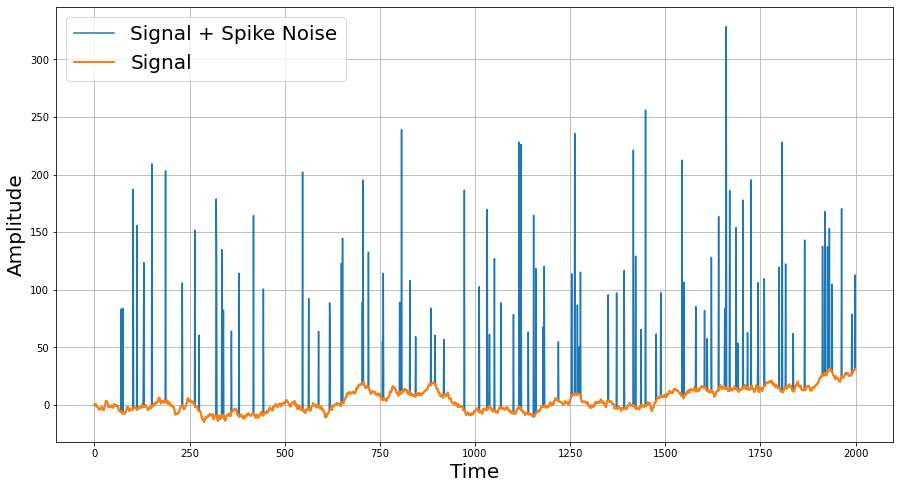

In [26]:
plt.figure(figsize = (15,8))
plt.plot(signal_spike , label = 'Signal + Spike Noise')
plt.plot(signal , linewidth = 2 , label='Signal')
plt.grid()
plt.xlabel('Time',fontsize = 20)
plt.ylabel('Amplitude',fontsize = 20)
plt.legend(fontsize = 20) ; 

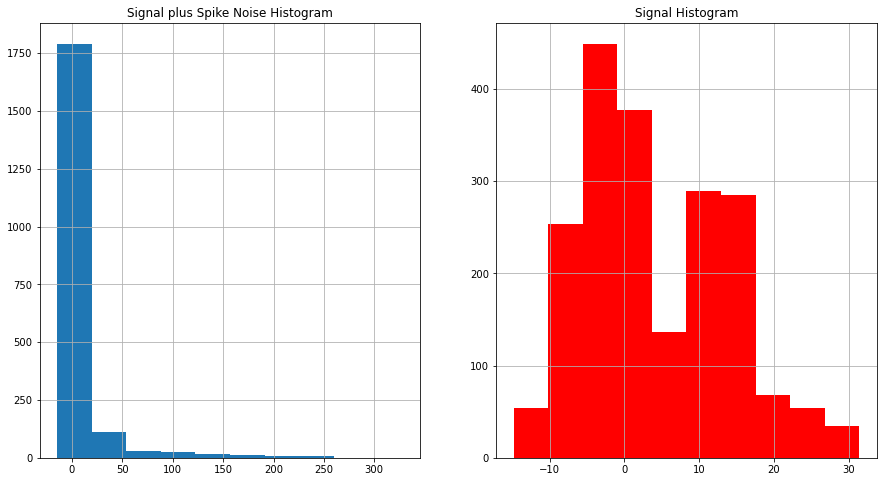

In [27]:
fig , ax = plt.subplots(nrows = 1,
                        ncols = 2,
                        figsize = (15,8))
ax[0].hist(signal_spike)
ax[0].grid()
ax[0].set_title('Signal plus Spike Noise Histogram')

ax[1].hist(signal , color = 'r')
ax[1].grid()
ax[1].set_title('Signal Histogram');

In [28]:
threshold_up = 50 # Based on Histogram
threshold_low = -10

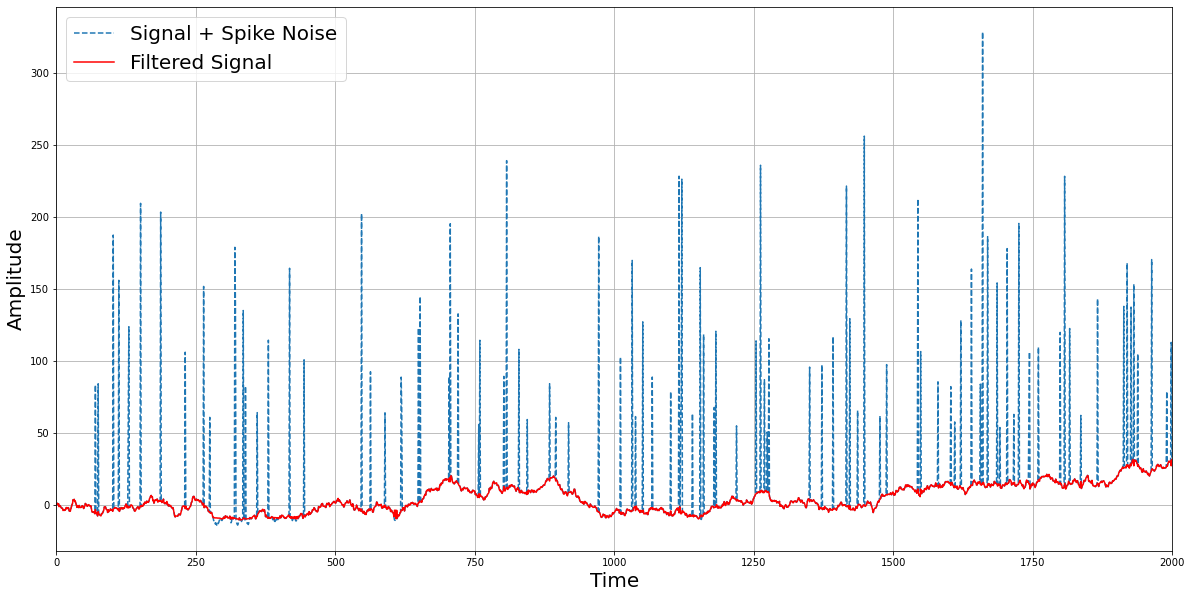

In [29]:
k = 20 # window For median Filter
filtered_signal = np.copy(signal_spike)
for i in range(len(signal_spike)):
    lower = np.max([0,i-k])
    upper = np.min([len(signal_spike) , i + k ])
    if (signal_spike[i] > threshold_up) or signal_spike[i] < threshold_low:
         filtered_signal[i] = np.median(signal_spike[lower:upper])
plt.figure(figsize = (20,10))
plt.plot(signal_spike , linestyle = 'dashed' , label = 'Signal + Spike Noise')
plt.plot(filtered_signal , label = 'Filtered Signal' , color = 'r')
plt.grid()
plt.xlim([0,2000])
plt.legend(fontsize = 20);
plt.xlabel('Time',fontsize = 20)
plt.ylabel('Amplitude',fontsize = 20);

## 6. Signal Detrending: 

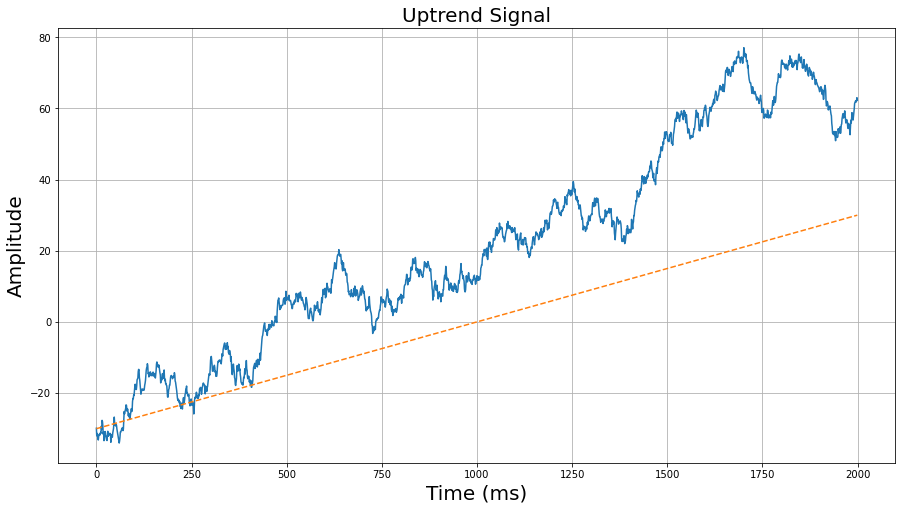

In [30]:
from scipy import signal as sig
n = 2000
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30,30,n)
plt.figure(figsize = (15,8))
plt.plot(signal)
plt.plot(np.linspace(-30,30,n) , linestyle = 'dashed')
plt.title('Uptrend Signal', fontsize = 20)
plt.xlabel('Time (ms)' , fontsize = 20)
plt.ylabel('Amplitude' , fontsize = 20)
plt.grid();

In [31]:
detrend_signal = sig.detrend(signal , type = 'linear')

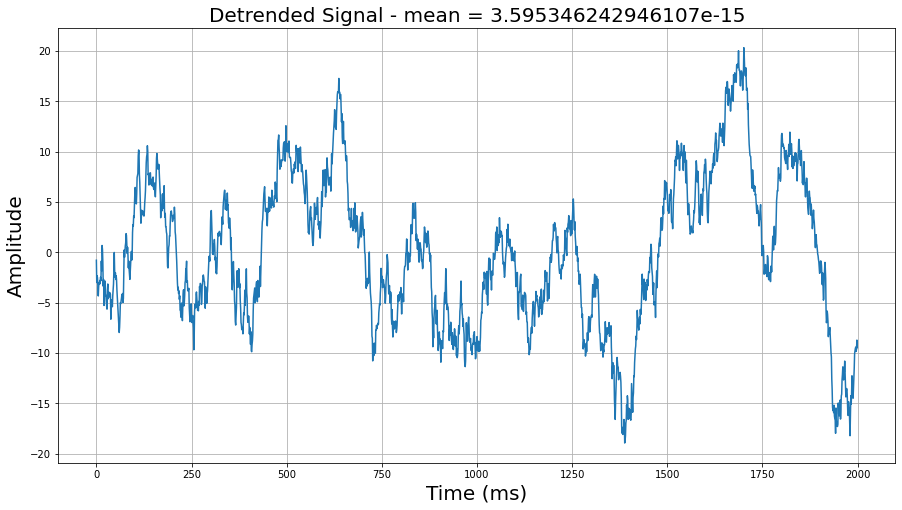

In [32]:
plt.figure(figsize = (15,8))
plt.plot(detrend_signal)
plt.title('Detrended Signal - mean = {}'.format(np.mean(detrend_signal)), fontsize = 20)
plt.xlabel('Time (ms)' , fontsize = 20)
plt.ylabel('Amplitude' , fontsize = 20)
plt.grid();

what about polynomial trends? 

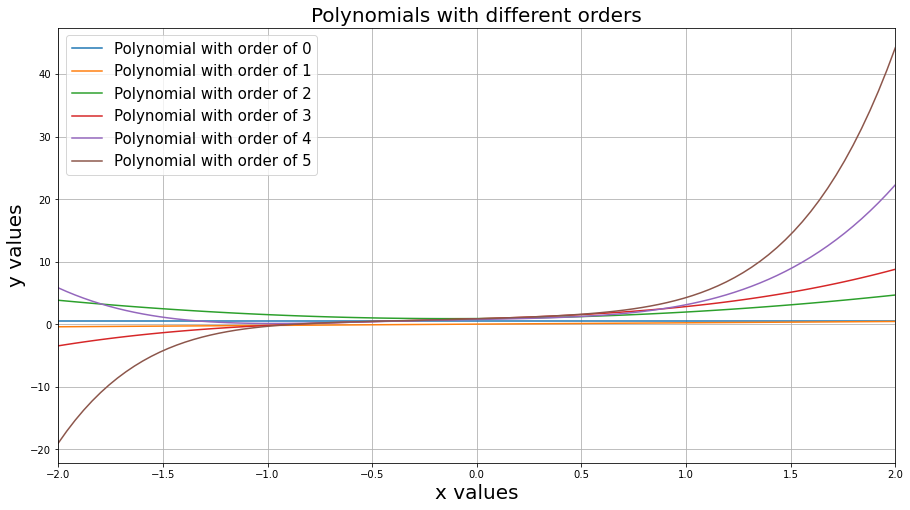

In [33]:
plt.figure(figsize = (15,8))
n = 100
num = 2
x = np.linspace(-num,num,n)
for order in range(1,7):
    y = np.zeros(n)
    for i in range(order):
        y = y + np.random.rand()*x**(i)
    plt.plot(x,y,label='Polynomial with order of {}'.format(order-1))
plt.title('Polynomials with different orders', fontsize = 20)
plt.xlabel('x values' , fontsize = 20)
plt.ylabel('y values' , fontsize = 20)
plt.legend(fontsize = 15)
plt.xlim([-num,num])
plt.grid();

In [34]:
n = 1000
time = np.arange(n)
k = 10 
slowdrift = interpolate.interp1d(np.linspace(1,k,k) , 100*np.random.randn(k))(np.linspace(1,k,n))
signal = slowdrift + 40*np.random.randn(n)

In [35]:
orders = np.arange(5,40)
Square_Error = np.zeros(len(orders))
for index_order in range(len(orders)):
    y_est = np.polyval(np.polyfit(time,signal,orders[index_order]) , time)
    Square_Error[index_order] = np.mean((y_est-signal)**2)

E:\Python\conda_project\first_project\env\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Python\conda_project\first_project\env\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Python\conda_project\first_project\env\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Python\conda_project\first_project\env\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Python\conda_project\first_project\env\lib\site-packages\IPython\core\interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
E:\Python\

In [36]:
BIC = n*np.log(Square_Error) + orders*np.log(n) # Bays Information Criteria

In [37]:
from matplotlib import patches

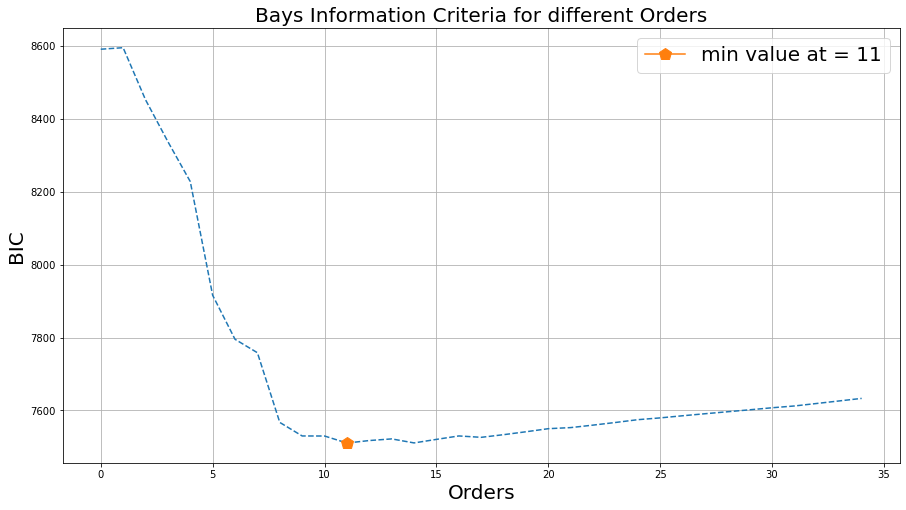

In [38]:
fig,ax = plt.subplots(figsize = (15,8))
ax.plot(BIC , linestyle = 'dashed')
plt.plot(BIC.argmin() , BIC.min() , marker = 'p' , markersize = 12 , label= 'min value at = {}'.format(BIC.argmin()))
ax.set_title('Bays Information Criteria for different Orders', fontsize = 20)
ax.set_xlabel('Orders' , fontsize = 20)
ax.set_ylabel('BIC' , fontsize = 20)
ax.legend(fontsize = 20)
ax.grid();

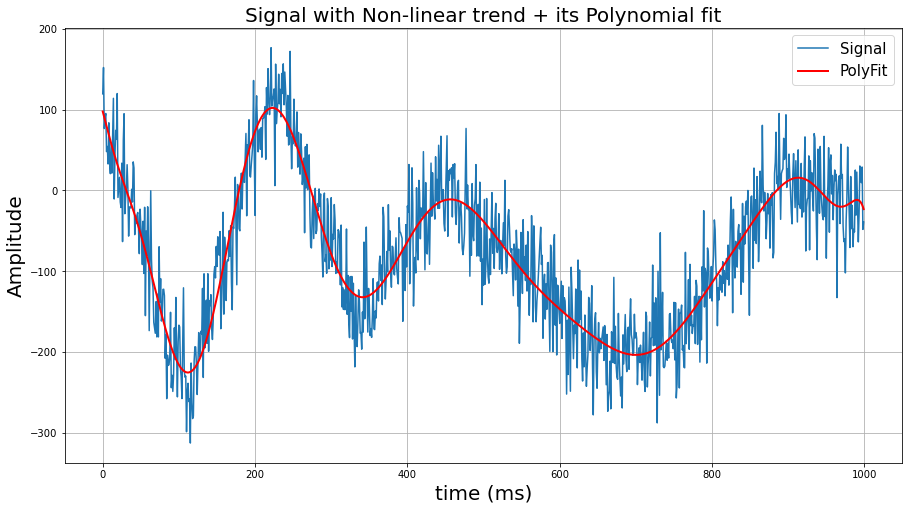

In [39]:
y_est = np.polyval(np.polyfit(time,signal,orders[BIC.argmin()]) , time)
plt.figure(figsize = (15,8))
plt.plot(signal , label = 'Signal')
plt.plot(y_est , label = 'PolyFit' , linewidth = 2 , color = 'r')
plt.title('Signal with Non-linear trend + its Polynomial fit', fontsize = 20)
plt.xlabel('time (ms)' , fontsize = 20)
plt.ylabel('Amplitude' , fontsize = 20)
plt.legend(fontsize = 15)
plt.grid();

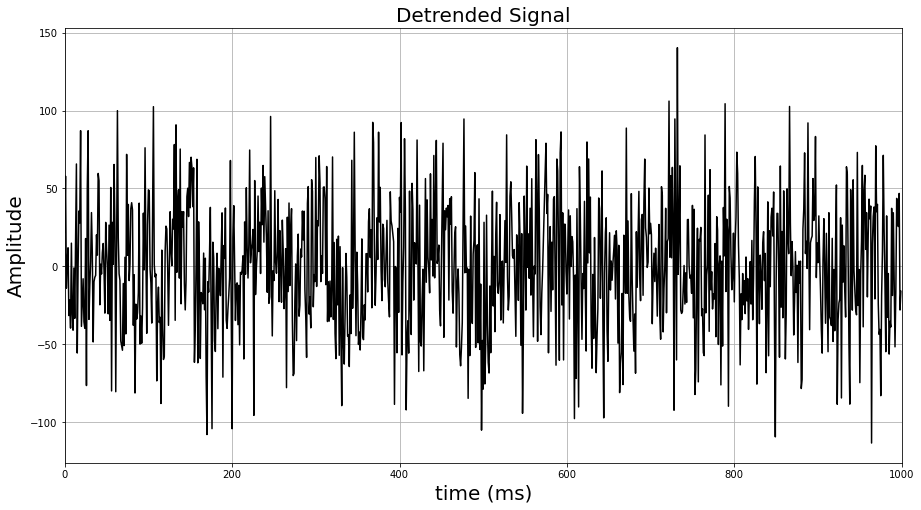

In [40]:
plt.figure(figsize = (15,8))
plt.plot(signal-y_est,color ='black')
plt.title('Detrended Signal', fontsize = 20)
plt.xlabel('time (ms)' , fontsize = 20)
plt.ylabel('Amplitude' , fontsize = 20)
plt.xlim([0,1000])
plt.grid();

## 7. Averaging multiple repetitions (time-synchronous averaging)

In [41]:
k = 100
event = np.diff(np.exp(-np.linspace(-2,2,k+1)**2))
event = event / event.max()

In [42]:
Nevents = 30 
data_length = 10000
random_list = np.random.permutation(data_length - k)
onset_times = random_list[:Nevents]

In [43]:
data = np.zeros(data_length)
for ei in range(Nevents):
    data[onset_times[ei]:onset_times[ei]+k] = event 

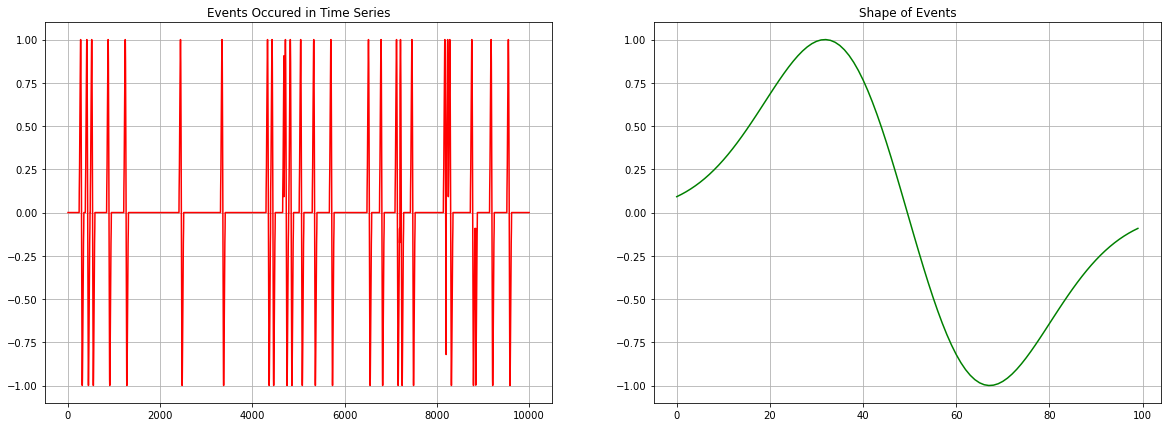

In [44]:
fig,ax = plt.subplots(nrows=1 , ncols=2 , figsize = (20,7))
ax[0].plot(data , color = 'r')
ax[0].set_title('Events Occured in Time Series')
ax[0].grid();

ax[1].plot(event, color = 'g')
ax[1].set_title('Shape of Events')
ax[1].grid();

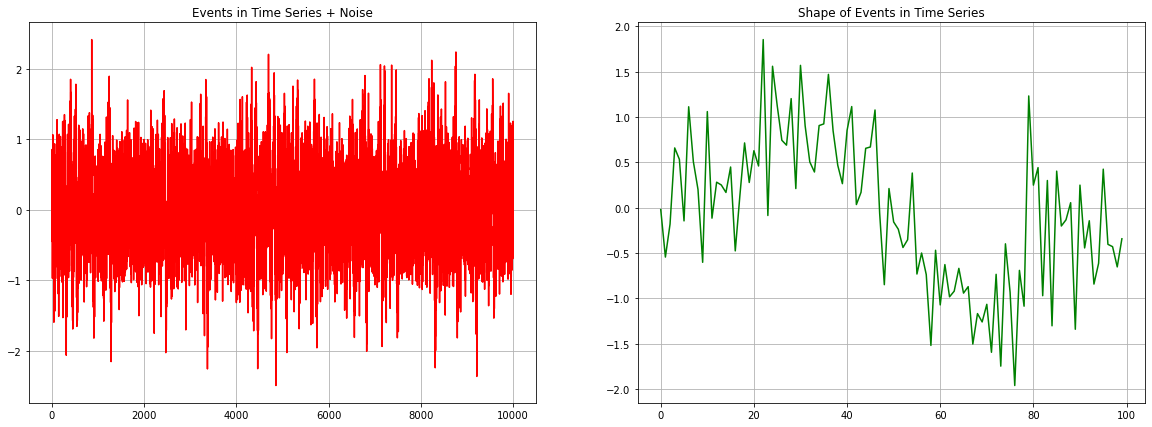

In [45]:
data_Noise = data + 0.5*np.random.randn(data_length)

fig,ax = plt.subplots(nrows=1 , ncols=2 , figsize = (20,7))
ax[0].plot(data_Noise , color = 'r')
ax[0].set_title('Events in Time Series + Noise')
ax[0].grid();

ax[1].plot(data_Noise[onset_times[2]:onset_times[2]+k], color = 'g')
ax[1].set_title('Shape of Events in Time Series')
ax[1].grid();

Creating DataMatrix ... 

In [46]:
data_matrix = np.zeros((Nevents , k))
for ei in range(Nevents):
    data_matrix[ei] = data_Noise[onset_times[ei]:onset_times[ei]+k]

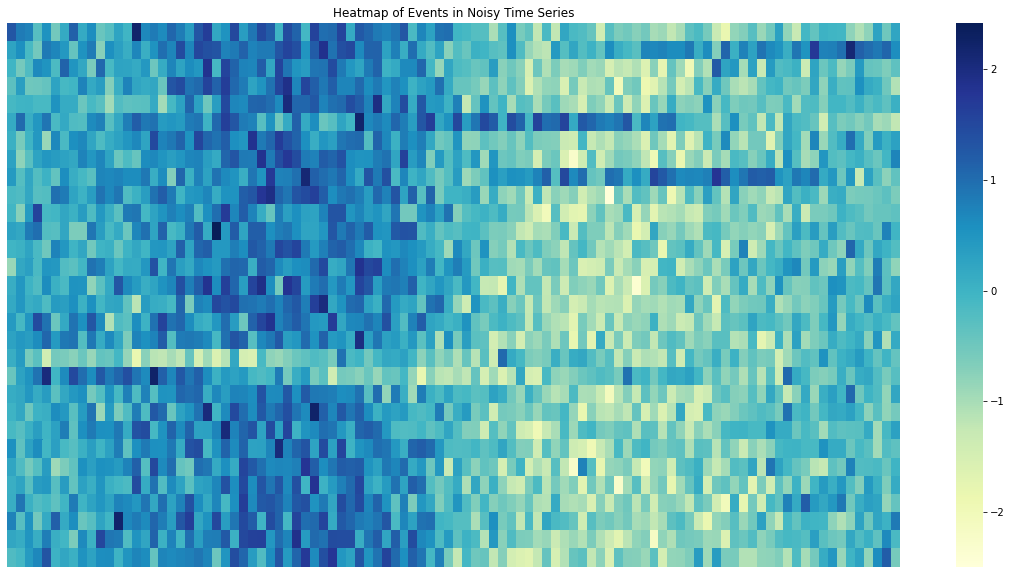

In [47]:
import seaborn as sns
plt.figure(figsize = (20,10))
plt.title('Heatmap of Events in Noisy Time Series')
sns.heatmap(data_matrix , cmap="YlGnBu" , cbar = True , xticklabels=False,
    yticklabels=False);

In [48]:
data_ave = np.mean(data_matrix , axis=0)

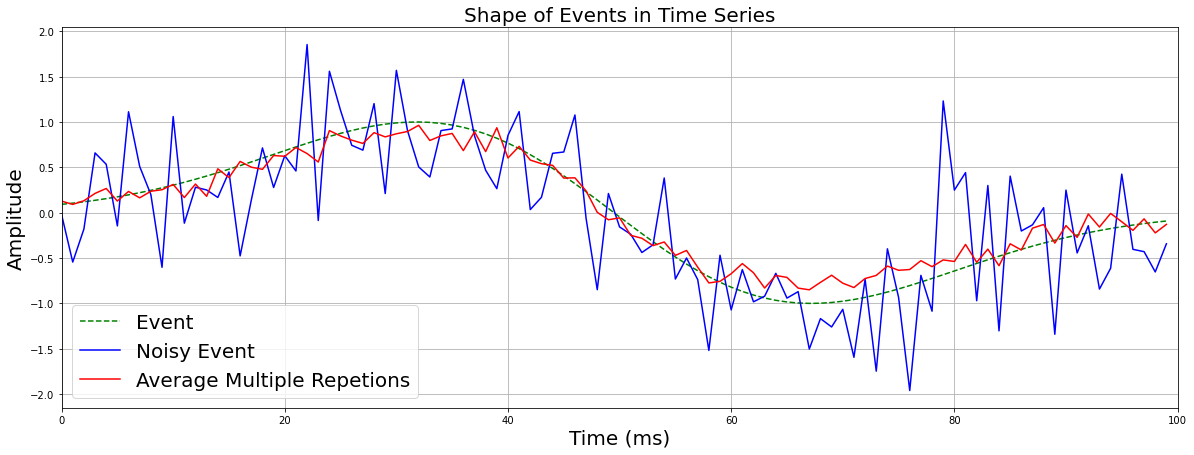

In [49]:
fig,ax = plt.subplots(figsize = (20,7))
ax.plot(event , color = 'g' , linestyle = 'dashed' , label = 'Event')
ax.plot(data_Noise[onset_times[2]:onset_times[2]+k], color = 'b' , label = 'Noisy Event')
ax.plot(data_ave, color = 'r' , label = 'Average Multiple Repetions')
ax.set_title('Shape of Events in Time Series',fontsize = 20)
ax.set_xlim([0 , k])
ax.set_xlabel('Time (ms)' , fontsize = 20)
ax.set_ylabel('Amplitude' , fontsize = 20)
ax.legend(fontsize = 20)
ax.grid();

## 8. Remove artifact via least-squares template-matching

In [50]:
x = loadmat('templateProjection.mat')
EEGdat = x['EEGdat']
eyedat = x['eyedat']
timevec = x['timevec']

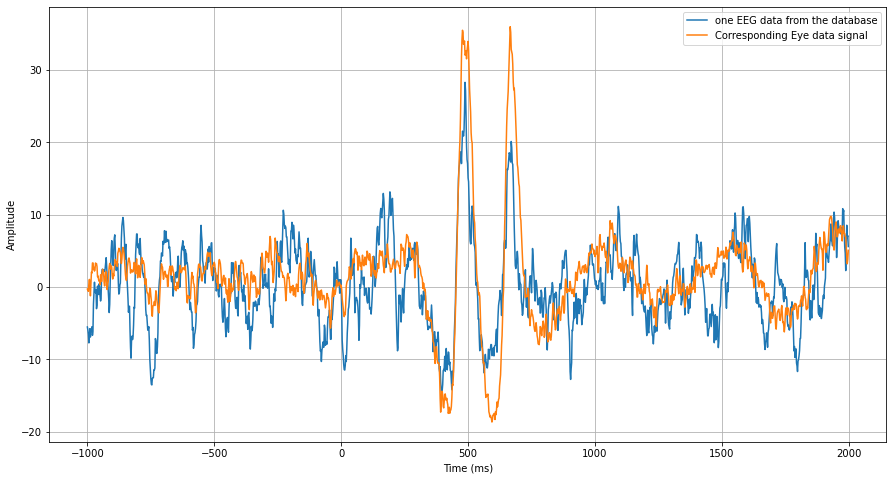

In [51]:
plt.figure(figsize = (15,8))
plt.plot(timevec[0] , EEGdat[:,0] , label = 'one EEG data from the database')
plt.plot(timevec[0] , eyedat[:,0] , label = 'Corresponding Eye data signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)') 
plt.grid()
plt.legend();

In [52]:
resdat = np.zeros(EEGdat.shape)
for traili in range(EEGdat.shape[1]):
    X = np.array([np.ones(eyedat.shape[0]) , eyedat[:,traili]])
    X = X.T
    b = (np.linalg.inv(X.T.conj().dot(X))).dot(X.conj().T.dot(np.reshape(EEGdat[:,traili] , (-1,1))))
    y_hat = X.dot(b)
    resdat[:,traili] = EEGdat[:,traili] - y_hat.T

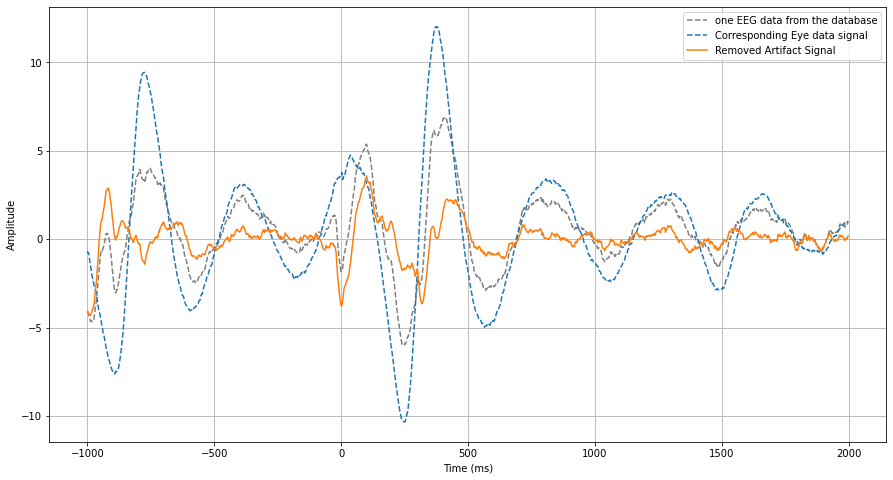

In [53]:
plt.figure(figsize = (15,8))
plt.plot(timevec[0] , np.mean(EEGdat , axis = 1) , 
         label = 'one EEG data from the database' , linestyle = 'dashed' , color = 'grey')
plt.plot(timevec[0] , np.mean(eyedat , axis = 1) , 
         label = 'Corresponding Eye data signal'  , linestyle = 'dashed' )
plt.plot(timevec[0] , np.mean(resdat , axis = 1) ,
         label = 'Removed Artifact Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)') 
plt.grid()
plt.legend();

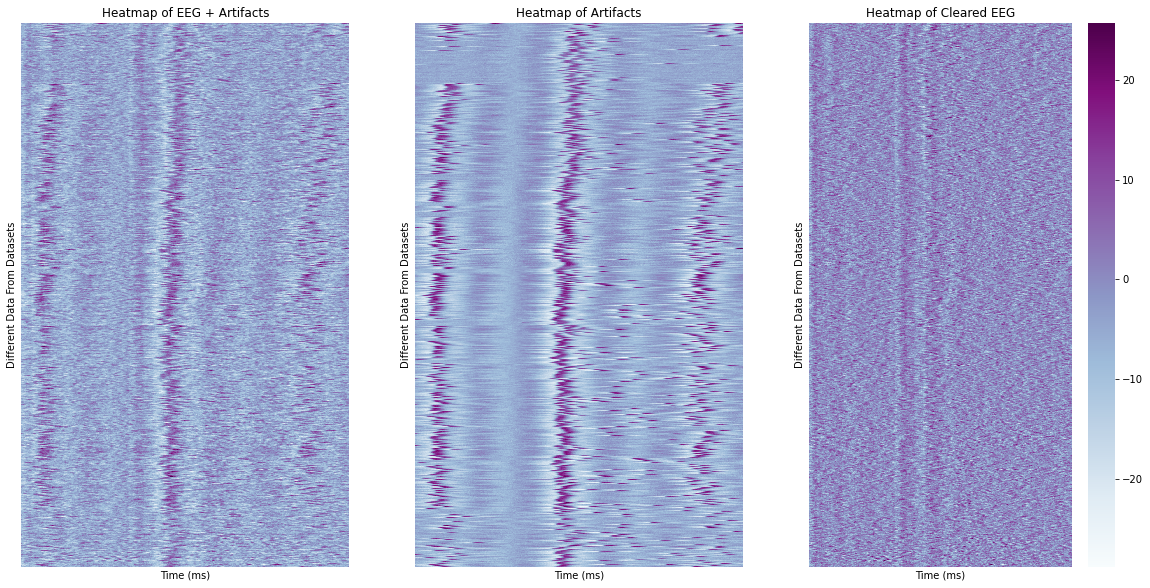

In [54]:
fig , ax = plt.subplots(nrows = 1 , ncols = 3 , figsize = (20,10))
ax[0].set_title('Heatmap of EEG + Artifacts')
sns.heatmap(EEGdat.T , cmap="BuPu" , cbar = False , xticklabels=False , yticklabels=False , ax = ax[0]);
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Different Data From Datasets');

ax[1].set_title('Heatmap of Artifacts')
sns.heatmap(eyedat.T , cmap="BuPu" , cbar = False , xticklabels=False , yticklabels=False , ax = ax[1]);
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Different Data From Datasets');

ax[2].set_title('Heatmap of Cleared EEG')
sns.heatmap(resdat.T , cmap="BuPu" , cbar = True , xticklabels=False , yticklabels=False , ax = ax[2]);
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Different Data From Datasets');

## 10. Code challenge Denoise these signals!

In [55]:
x = loadmat('denoising_codeChallenge.mat')
Original_signal = x['origSignal'].T
Clean_signal = x['cleanedSignal'].T

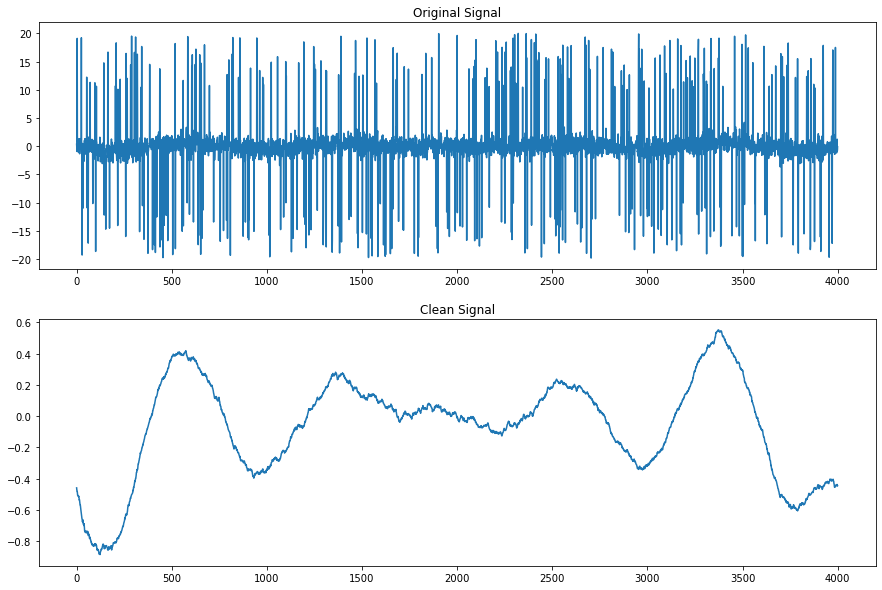

In [56]:
fig,ax = plt.subplots(figsize = (15,10) , nrows = 2 , ncols = 1)
ax[0].plot(Original_signal)
ax[0].set_title('Original Signal')
ax[1].plot(Clean_signal)
ax[1].set_title('Clean Signal');

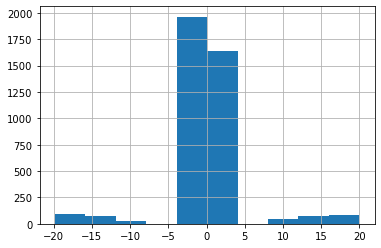

In [57]:
plt.hist(Original_signal)
plt.grid();

In [58]:
# Based on Histogram:
thr_up = 5
thr_down = -5
k = 50 
num = len(Original_signal)
SpikeFilter_signal = np.zeros(num)
for i in range(k , num-k):
    if Original_signal[i] > thr_up or Original_signal[i] < thr_down:
        SpikeFilter_signal[i] = np.median(Original_signal[i-k:i+k])
    else: 
        SpikeFilter_signal[i] = Original_signal[i]
    

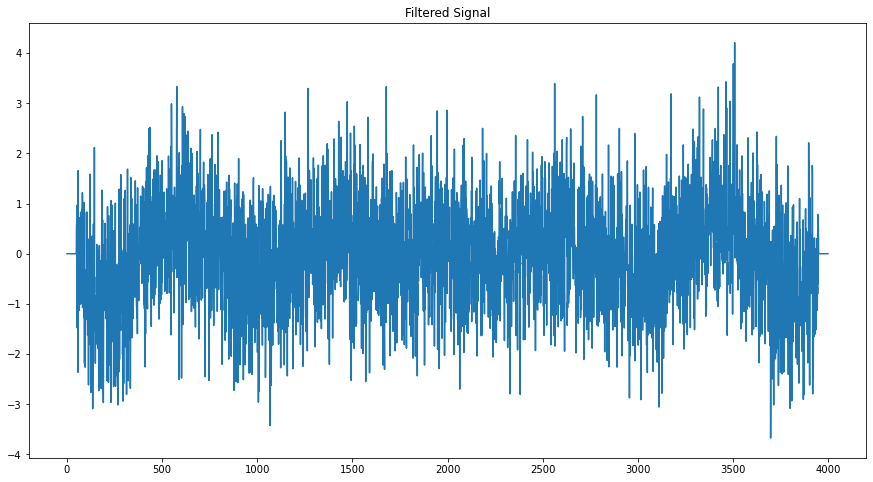

In [59]:
plt.figure(figsize = (15,8))
plt.title('Filtered Signal')
plt.plot(SpikeFilter_signal);

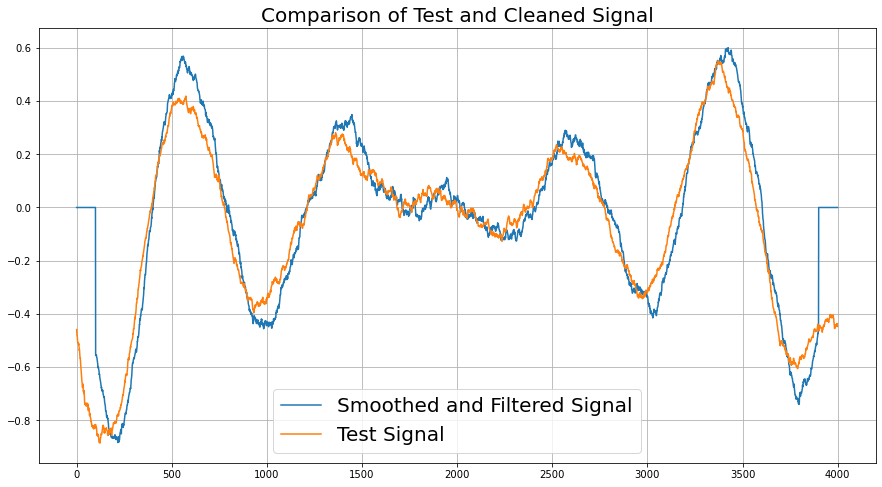

In [60]:
# Full-width Half-Maximum 
fwhm = 400 # in ms
k = 100
Precision = 1
gtime = Precision * np.arange(-k,k)
gaussian = np.exp(-(4*np.log(2)*gtime**2)/fwhm**2)
Smooth_signal = np.zeros(num)
for i in range(k,num-k):
    Smooth_signal[i] = np.mean(SpikeFilter_signal[i-k:i+k]*gaussian)
plt.figure(figsize = (15,8))
plt.plot(Smooth_signal , label = 'Smoothed and Filtered Signal')
plt.plot(Clean_signal  , label = 'Test Signal')
plt.grid()
plt.title('Comparison of Test and Cleaned Signal' , fontsize = 20)
plt.legend(fontsize = 20);